In [20]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
import numpy as np
# import torch
# import torchvision
import matplotlib.pyplot as plt
from time import time
# from torchvision import datasets, transforms
# from torch import nn, optim
import random
random_state = 10 # Ensure reproducible results
%matplotlib inline

In [21]:
def masking_data (data):
    masked_data = data.copy()
    y = []
    for i in range(len(data)):
        indexs = np.where(masked_data[i]==1)[0]
        random_index = random.randint(0,len(indexs)-1)
        masked_data[i][indexs[random_index]] = 0
        y.append(indexs[random_index])
    return masked_data,y

In [22]:
index = np.where(recipe_mat[0]==1)
index[0]

array([ 90, 148, 182, 219, 269, 291, 488, 545, 562, 572, 586, 609, 664,
       679, 694])

In [23]:
testbed_mat = loadmat('Queries/suggestion_testbed.mat')
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
ing_headline.append('label')
dataset_X,dataset_y = masking_data(recipe_mat)
dataset_X = np.concatenate([dataset_X,labels_mat],axis=1)
dataset_X = pd.DataFrame(dataset_X,columns=ing_headline)
dataset_y = pd.DataFrame(dataset_y,columns=['label'])
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25)


In [148]:
X_train.iloc[:,:-1].sum()

acorn squash                      0
adobo                             3
african birdseye chile pepper     3
ale                               2
aleppo pepper                     1
                                 ..
yellow squash                     6
yogurt                           81
zaatar                            0
zest                              6
zucchini                         73
Length: 709, dtype: int64

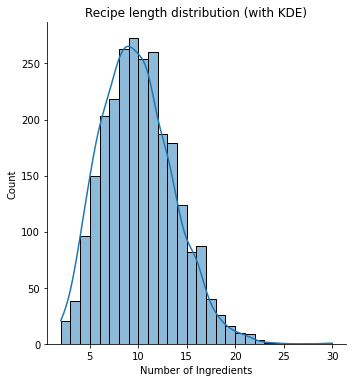

In [144]:
## -- Plot number of ingredients
ax = sns.displot(np.sum(X_train.iloc[:,:-1],axis=1), bins=np.linspace(1,29,29)+1,kde=True)
ax.set(xlabel="Number of Ingredients", title="Recipe length distribution (with KDE)")

<AxesSubplot:title={'center':'Top 20 ingredients'}>

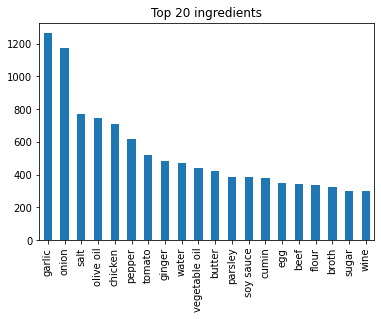

In [153]:
#--- top 10 most used ingredients
fig, ax = plt.subplots()
# sum up occurences of each ingredient
freq_ing = X_train.iloc[:,:-1].sum()
# filter for the 10 most frequent
most_freq_ing = freq_ing.nlargest(20)
ax.set_title("Top 20 ingredients")
most_freq_ing.plot.bar()

In [86]:
def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt = '.2f'
    
    # Your code goes here
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Your code goes here

def dummy_pipe(X_train, y_train, dummy_strategy):
    
    # dummy classifier
    dclf = DummyClassifier(strategy=dummy_strategy)
    
    # construct the pipeline
#     pipe = Pipeline([('scaler', StandardScaler()), ('dclf', dclf)])
    pipe = Pipeline([('dclf', dclf)])
    # train
    pipe.fit(X_train, y_train)  # we do not need the _sc variable

    return pipe

pipe_mf = dummy_pipe(X_train, y_train, 'most_frequent')
val_score_mf = pipe_mf.score(X_val, y_val)

# Note: since labels are guessed randomly, different runs give different results
pipe_strat = dummy_pipe(X_train, y_train, 'stratified')  
val_score_strat = pipe_strat.score(X_val, y_val)

#
pipe_prior = dummy_pipe(X_train, y_train, 'prior')
val_score_prior = pipe_mf.score(X_val, y_val)

pipe_uni = dummy_pipe(X_train, y_train,'uniform')
val_score_uni = pipe_mf.score(X_val, y_val)


print("Classification accuracy on the validation set:")
print("'Most-frequent' dummy classifier: {0:.3f}".format(val_score_mf))
print("'Stratified' dummy classifier: {0:.3f}".format(val_score_strat))
print("'prior' dummy classifier: {0:.3f}".format(val_score_prior))
print("'uniform' dummy classifier: {0:.3f}".format(val_score_uni))


Classification accuracy on the validation set:
'Most-frequent' dummy classifier: 0.058
'Stratified' dummy classifier: 0.013
'prior' dummy classifier: 0.058
'uniform' dummy classifier: 0.058


In [87]:
# standardisation
# sc = StandardScaler().fit(X_train)
# X_train_sc = sc.transform(X_train)
# X_val_sc = sc.transform(X_val)
# X_test_sc = sc.transform(X_test)  # needed below
X_train_sc = X_train
X_val_sc = X_val
names = ["Dummy, most frequent", "Gaussian Naive Bayes", "Logistic Regression",
         "Nearest Neighb (10)", "Nearest Neighb (5)",
         "Linear SVM", "RBF SVM",
         "Random Forest", "MLP", "MLP stronger reg", "LDA", "QDA"]
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    GaussianNB(),
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=5), 
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=800),  # default regularisation
    MLPClassifier(random_state=random_state, max_iter=800, alpha=1),  # more regularisation
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_train_sc, y_train)
    
    ca_train_score[name] = clf.score(X_train_sc, y_train)
    ce_train_score[name] = log_loss(y_train, clf.predict_proba(X_train_sc))
    
    ca_val_score[name] = clf.score(X_val_sc, y_val)
    ce_val_score[name] = log_loss(y_val, clf.predict_proba(X_val_sc))


print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

ValueError: y_true and y_pred contain different number of classes 203, 342. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [  1   8  17  26  29  33  38  39  47  52  53  54  55  60  64  65  73  78
  81  82  85  87  88  90  94  99 101 102 107 110 113 114 115 118 119 121
 128 130 136 140 141 142 143 145 146 153 157 158 159 160 163 166 168 172
 173 174 182 183 192 193 195 196 200 201 204 205 212 213 219 220 223 226
 232 240 245 247 251 261 263 264 265 269 275 289 291 295 297 302 303 308
 311 312 313 315 318 331 333 342 348 353 355 356 357 361 366 367 376 377
 385 391 393 394 401 403 406 407 410 411 416 420 421 422 423 425 426 427
 428 430 436 438 440 441 442 444 448 450 451 458 468 470 472 475 488 490
 500 501 517 519 524 528 529 532 535 540 542 545 546 550 551 562 563 564
 565 570 572 579 581 584 586 591 596 607 609 615 616 621 623 625 635 636
 637 640 642 644 647 651 653 654 655 661 664 672 678 679 680 687 688 694
 695 697 705 707 708]

In [85]:
dataset_full

array([[ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       ...,
       [ 0,  0,  0, ...,  0,  0, 12],
       [ 0,  0,  0, ...,  0,  0, 12],
       [ 0,  0,  0, ...,  0,  0, 12]], dtype=uint8)

In [ ]:
# pick random forest
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_full, y_train_full)
ca_rf_test = clf.score(X_test, y_test)
ce_rf_test = log_loss(y_test, clf.predict_proba(X_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("Log-loss:", ce_rf_test)

In [28]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
train_X = torch.tensor(X_train.to_numpy())
train_y = torch.tensor(y_train.to_numpy())

# Hyper parameters

num_epochs = 35
num_classes = 2
batch_size = 25
learning_rate = 0.001

In [32]:
X_train_before_mask

array([[ 0,  0,  0, ...,  0,  0,  2],
       [ 0,  0,  0, ...,  0,  0,  7],
       [ 0,  0,  0, ...,  0,  0,  3],
       ...,
       [ 0,  0,  0, ...,  0,  0, 11],
       [ 0,  0,  0, ...,  0,  0,  9],
       [ 0,  0,  0, ...,  0,  0, 12]], dtype=uint8)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
len(recipe_mat)

In [ ]:
len(labels_mat)

In [ ]:
len(recipe_mat[0])

In [ ]:
train_dataset = np.concatenate((recipe_mat,labels_mat),axis=1)
len(train_dataset[0])

In [50]:
len(masked_index)

2541

In [ ]:
y_train

In [ ]:
dataset_full = np.concatenate((recipe_mat,labels_mat),axis=1)
train_dataset,test_dataset = train_test_split(dataset_full,test_size=0.2)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Hyper parameters
num_epochs = 5
num_classes = 12
batch_size = 50
learning_rate = 0.001

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
class ConvNet(nn.Module):
    def __init__(self, num_classes=12):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out



In [ ]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, d in enumerate(train_loader):
        images = d[:,:-1]
        labels = d[:,-1]
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for d in test_loader:
        images = d[:,:-1]
        labels = d[:,-1]
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')